# Анализ результатов A/B-теста интернет магазина по увеличению выручки

<b>Предисловие</b> - в крупном интернет-магазине затронут вопрос увеличения выручки, отделом маркетинга подготовлены и выдвинуты на проверку соответствующие гипотезы, проведенно A/B-тестирование.

<b>Цель исследования</b> - проанализировать результы A/B-теста с целью принятия решению по продолжению или остановке теста. 

<b>Задачи в рамках исследования:</b>
- исследовать исходные данные;
- приоритезировать гипотезы;
- проанализировать результаты A/B-тестирования;
- сформировать итоговые выводы исследования.

<b>Исходные данные для исследования:</b>
- данные с выдвинутыми гипотезами;
- результаты A/B-теста.

<div align='right'>Проектную работу выполнил студент Гагиев Денис. </div>

---

### Изучение и предобработка исходных данных

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# настройки библиотек
pd.set_option('display.max_colwidth', 0)

In [3]:
# создание датафреймов
try:
    hypothesis, orders, visitors = (
        pd.read_csv('/Users/dendon/Desktop/Обучение/YP/Спринт 7 - Принятие решений в бизнесе./Проект/hypothesis.csv'),
        pd.read_csv('/Users/dendon/Desktop/Обучение/YP/Спринт 7 - Принятие решений в бизнесе./Проект/orders.csv'),
        pd.read_csv('/Users/dendon/Desktop/Обучение/YP/Спринт 7 - Принятие решений в бизнесе./Проект/visitors.csv')
    )
except:
    hypothesis, orders, visitors = (
        pd.read_csv('ссылка скрыта'),
        pd.read_csv('ссылка скрыта'),
        pd.read_csv('ссылка скрыта')
    )

In [4]:
# предварительное изучение датафреймов

display(hypothesis.head())

display(orders.head())
display(orders.info())

display(visitors.head())
display(visitors.info())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

**Комментарий:** 9 гипотез, каждая из которых проранжированы по 4-м основным параметрам reach, impact, confidence и efforts, что позволит произвести дальнейшую приоритезацию гипотез методами ICE и RICE.  
Среди остальных датафреймов есть нюансы стиля оформления и формата столбцов. 

#### Предобработка данных

In [5]:
# убираем верхний регистр в hypothesis
hypothesis.columns = hypothesis.columns.str.lower()

# имя столбцов в orders
orders.columns = [name.replace('Id', '_id') for name in orders.columns]

# меняем формат данных столбцов с датами
for df in orders, visitors:
    df['date'] = pd.to_datetime(df['date'])
    
# поиск дубликатов в переменных orders и visitors
orders.duplicated().sum()
visitors.duplicated().sum()

0

**Комментарий:** в рамках предобработки данных выполнены следующие действия:  
- названия столбцов в "hypothesis" приведены к нижнему регистру;
- создано более корректное разделение названия столбцов в "orders";
- изменен формат данных в столбцах с датами в "orders" и "visitors".

---

### Часть 1 - Приоритизация гипотез

На данном этапе будет проведена приоритизация гипотез по методам ICE и RICE.

In [6]:
# приоритизация методом ICE
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis['ice'] = hypothesis['ice'].round(1)
hypothesis.sort_values(by='ice', ascending=False).head(4)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0


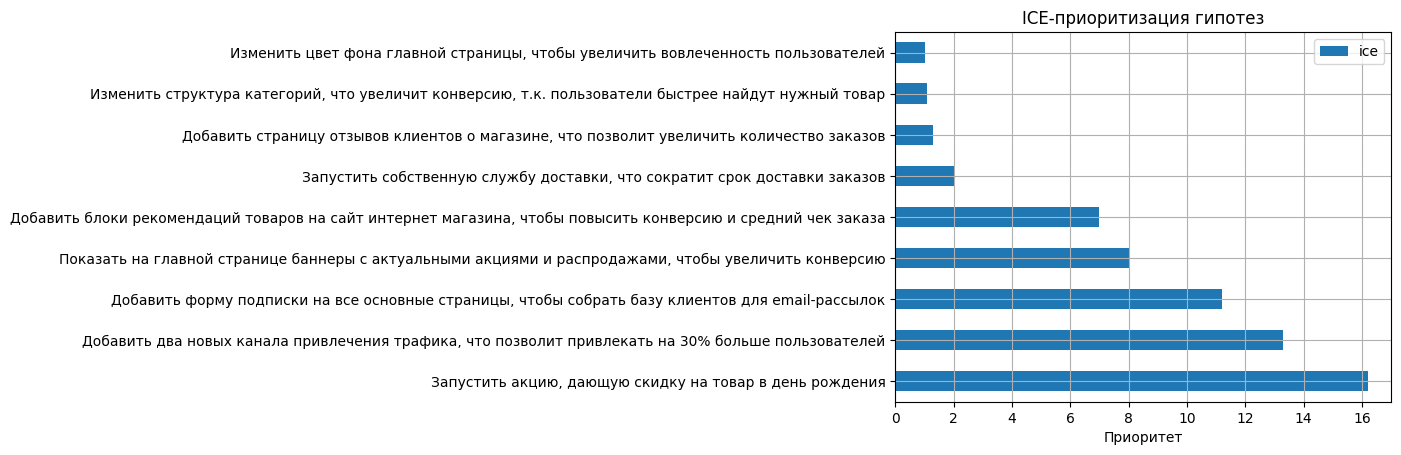

In [7]:
# визуалиация метода ICE
hypothesis[['hypothesis', 'ice']].set_index('hypothesis').sort_values(by='ice', ascending=False) \
.plot(kind='barh', grid=True, title='ICE-приоритизация гипотез')
plt.ylabel('')
plt.xlabel('Приоритет')
plt.show()

**Комментарий:** из общего списка гипотез согласно приоритизации методом ICE наиболее перспективные:
- запустить акцию, дающую скидку на товар в день рождения;
- добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;	
- добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

In [8]:
# приоритизация методом RICE
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis.sort_values(by='rice', ascending=False).head(4)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0


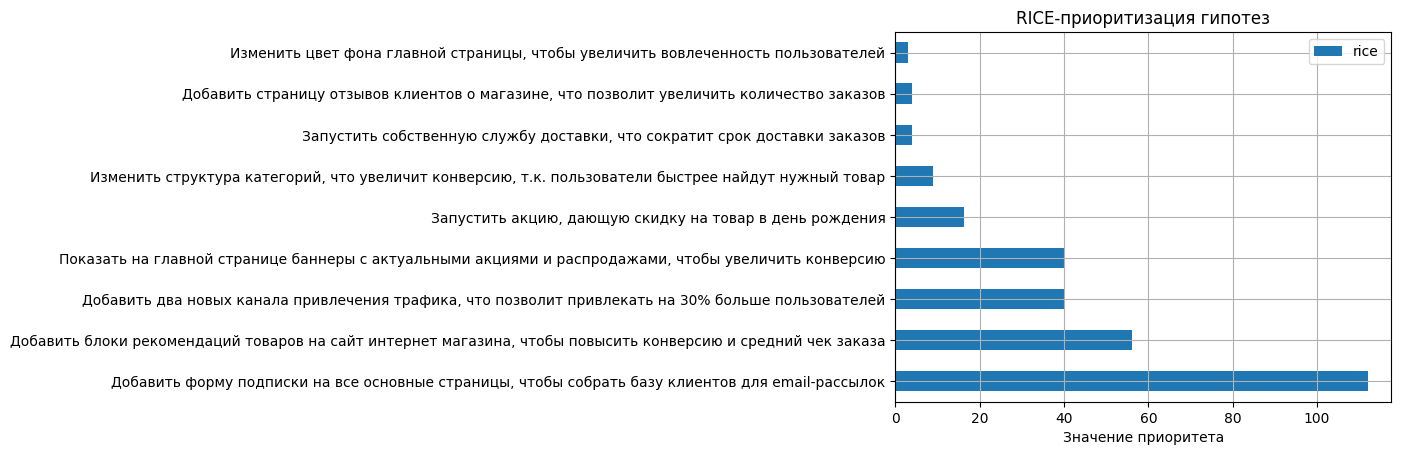

In [9]:
# визуалиация метода RICE
hypothesis[['hypothesis', 'rice']].set_index('hypothesis').sort_values(by='rice', ascending=False) \
.plot(kind='barh', grid=True, title='RICE-приоритизация гипотез')
plt.ylabel('')
plt.xlabel('Значение приоритета')
plt.show()

**Комментарий:** разница методов ICE и RICE заключается в компонентах, которые затрагивают данные методики. Метод ICE в своем расчете использует такие компоненты, как Impact (насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта), Confidence (насколько вы уверены, что это изменение повлияет на пользователей именно так), Efforts (сколько стоит протестировать эту гипотезу). В свою очередь метод RICE затрагивают помимо 3-х упомянутых еще одну 4-ю метрику Reach (скольких пользователей затронет изменение, которое вы хотите внести).  

При приоритизации методом RICE мы можем видеть, как параметр Reach сказался на топе гипотез. Из общего списка гипотез согласно приоритизации методом RICE наиболее перспективные:
- добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;	
- добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.  

Таким образом влияние метрики Reach и в целом метода RICE - гипотеза "добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", занимающая при расчете методом ICE 3-е место выходит на 1-е место, поскольку данная гипотеза будет захватывать очень большую часть аудитории продукта, что и учитывает метрика Reach.

---

### Часть 2 - Анализ A/B-теста

На данном этапе будут проанализированны исходные результаты A/B теста.

Подготовка данных:

In [31]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# соберём агрегированные кумулятивные данные о заказах
orders_agg = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])] \
    .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique',
          'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1) \
    .sort_values(by=['date','group'])

# соберём агрегированные кумулятивные данные о визитах
visitors_agg = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])] \
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1) \
    .sort_values(by=['date','group'])

# объединим кумулятивные данные в одной таблице, изменим названия столбцов
cumulative_data = orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


#### 2.1 Куммулятивная выручка по группам.

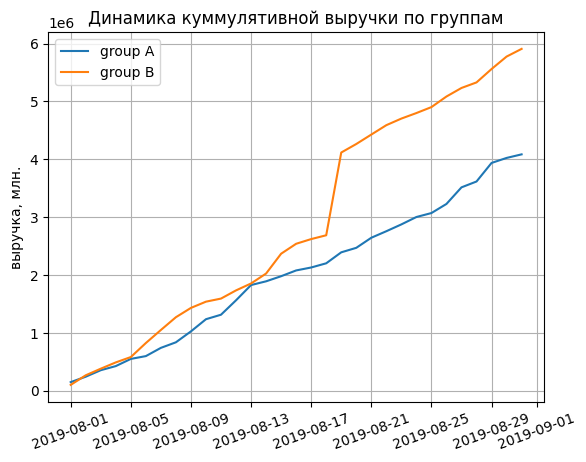

In [11]:
# разделим куммулятивные данные на группы A и B
cumulative_revenue_a = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

# построение графика
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='group A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='group B')
plt.title('Динамика куммулятивной выручки по группам'), plt.ylabel('выручка, млн.'), plt.legend()
plt.xticks(rotation=20), plt.grid(True)
plt.show()

**Комментарий:** обе группы имеют стабльный рост в течении всего времени теста, начиная с 17-го мая выручка группы "B" имеет краткосрочный значительный рост, возможно это указывает на резкое увеличение колличества заказов или выбросы в стоимости заказов.

#### 2.2 Куммулятивный средний чек по группам.

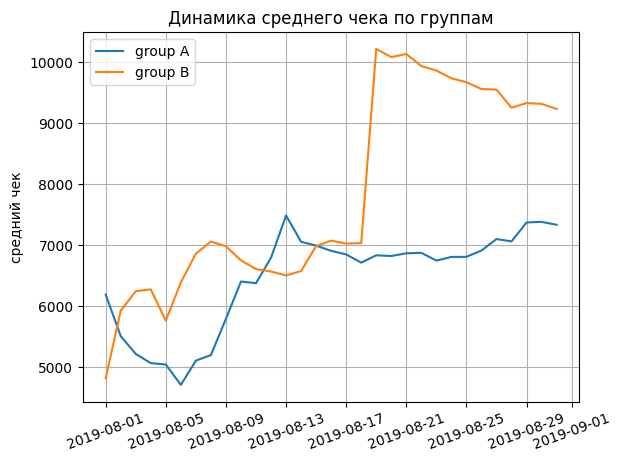

In [12]:
# построение графика
plt.plot(cumulative_revenue_a['date'],
         cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='group A')

plt.plot(cumulative_revenue_b['date'], 
         cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='group B')

plt.title('Динамика среднего чека по группам'), plt.ylabel('средний чек'), plt.legend()
plt.xticks(rotation=20), plt.grid(True)
plt.show()


**Комментарий:** как и было предположенно ранее, резкий рост динамики группы "B" является краткосрочным, поскольку средний чек выравнивается и даже имеет тенденцию падения после резкого роста примерно 18-го августа. Скорее всего, рост выручки группы "B" заключается именно в стоимости заказа.

#### 2.3 Относительное изменение кумулятивного среднего чека группы B к группе A.

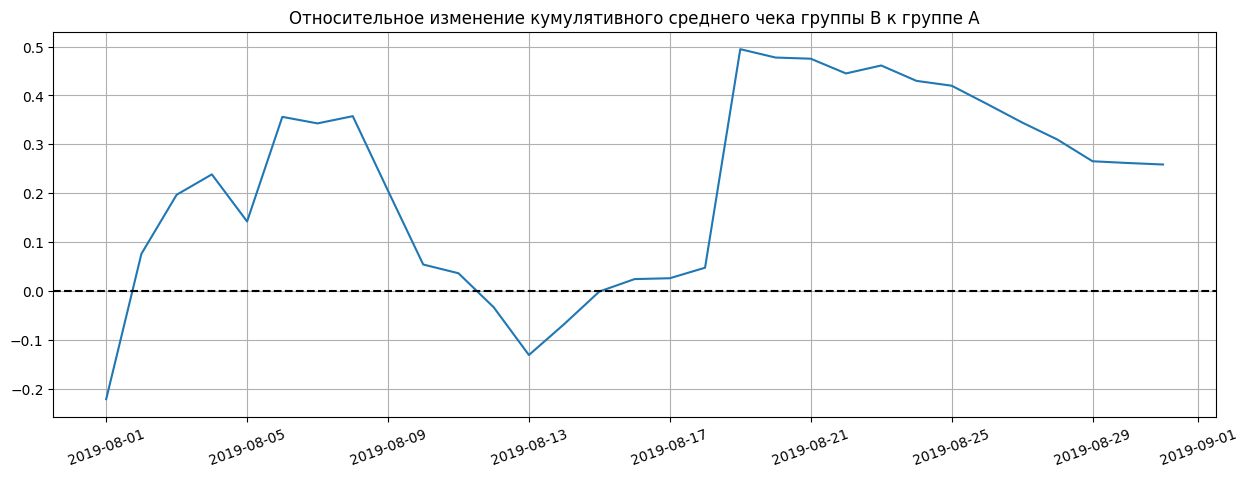

In [13]:
# собираем данные в одном датафрейме
merge_cumulative = cumulative_revenue_a.merge(
    cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15, 5))
plt.plot(
    merge_cumulative['date'],
    (merge_cumulative['revenueB']/merge_cumulative['ordersB'])
    /(merge_cumulative['revenueA']/merge_cumulative['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

# настраиваем график
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=20), plt.grid(True)
plt.show()

**Комментарий:** средний чек групп значительно разнится в нескольких местах, что снова указывает на возможное наличие выбросов в стоимости заказов.

#### 2.4 Кумулятивное среднее количество заказов на посетителя по группам.

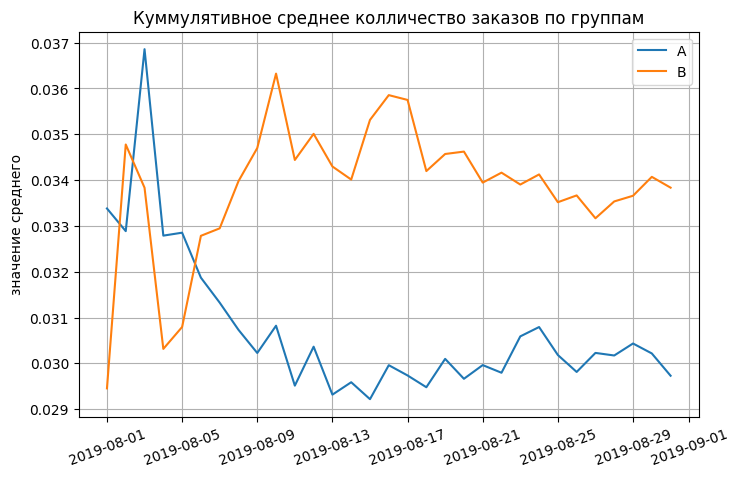

In [14]:
# считаем среднее кумулятивное колличество заказов
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a= cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.figure(figsize=(8, 5))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')

# настройки графика
plt.title('Куммулятивное среднее колличество заказов по группам'), plt.ylabel('значение среднего'), plt.legend()
plt.xticks(rotation=20), plt.grid(True)
plt.show()

**Комментарий:** есть значительные коллебания в начале графика, но далее среднее колличество заказов обоих групп имеет более статичный характер, среднее группы "B" выше среднего группы "А".

#### 2.5 Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A

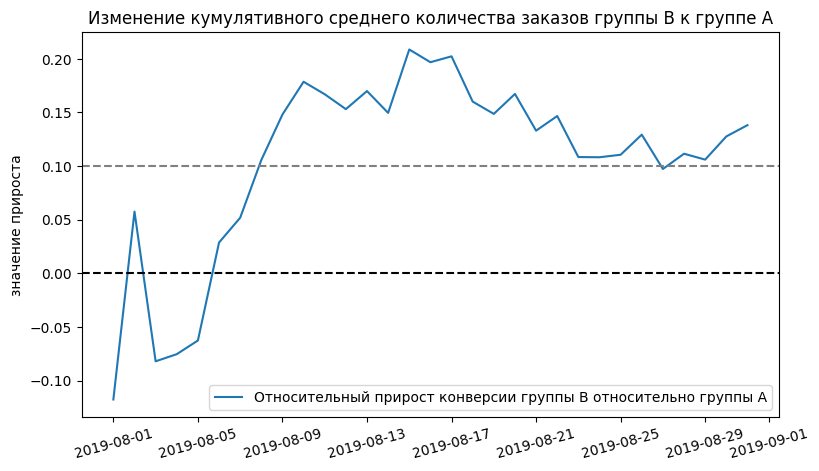

In [15]:
# вновь объединяем данные
merge_conversion = cumulative_data_a[['date','conversion']].merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# строим график
plt.figure(figsize=(9, 5))
plt.plot(merge_conversion['date'], merge_conversion['conversionB']/merge_conversion['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")

plt.legend()
plt.title('Изменение кумулятивного среднего количества заказов группы B к группе A')
plt.ylabel('значение прироста')
plt.xticks(rotation=15)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.show()

**Комментарий:** в начале графика наблюдается преимущество по колличеству заказов группы "А", далее видим относительный рост колличество заказов группы "В" вплоть до 20%, далее колличество заказов закрепляется и находится в похожих значениях. 

---

#### Изувич кумулятивные метрики, более подробно изучим заказы, посмотрим на наличие выбросов и крайних значений.
#### 2.6 Колличество заказов по пользователям.

In [16]:
# сгрупирруем заказы по пользователям
orders_group_users = (
    orders.groupby(by='visitor_id', as_index=False)
    .agg({'transaction_id' : 'nunique'})
)

orders_group_users.columns = [['user_id', 'cnt_orders']]

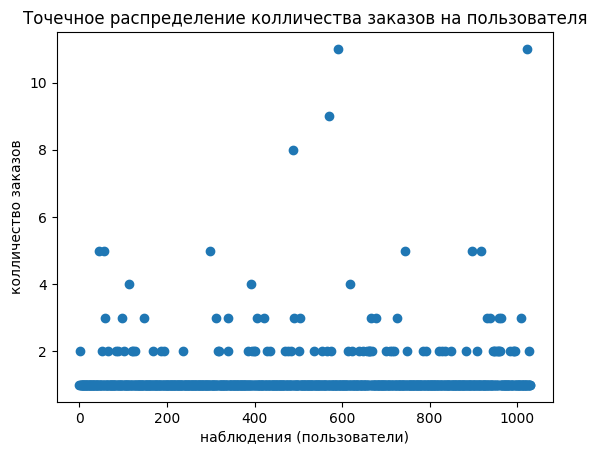

In [17]:
# серия из чисел от 0 до количества наблюдений в orders_group_users
x_values = pd.Series(range(0, len(orders_group_users)))

# график
plt.scatter(x_values, orders_group_users['cnt_orders'])
plt.title('Точечное распределение колличества заказов на пользователя')
plt.xlabel('наблюдения (пользователи)')
plt.ylabel('колличество заказов')
plt.show()

**Комментарий:** видим долю пользователей совершивших 2 заказа, более редкие пользователи с 3-мя заказами. Интересно, что пользователей, совершивших 5 заказов больше чем пользователей совершивших 4 заказа.

#### 2.7 95-й и 99-й перцентили количества заказов на пользователя.

In [18]:
np.percentile(orders_group_users['cnt_orders'], [95, 99])

array([2., 4.])

**Комментарий:** только 5% пользователей совершили 2 и более заказа, 1% пользователей совершли 4 и более заказа.  Границей для аномальных пользователей будет служить сумма заказов равная 4-м.


#### 2.8 Оценка стоимости заказов.

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

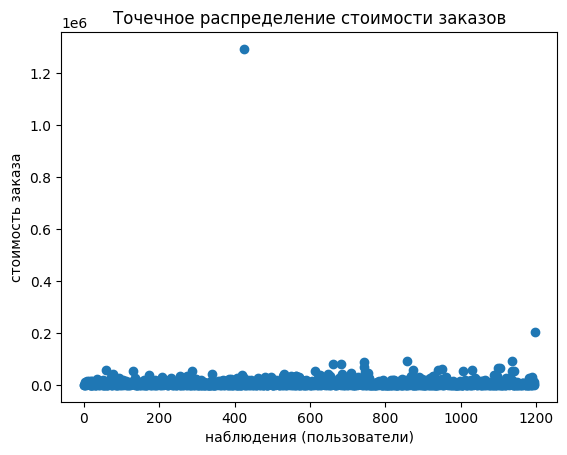

In [19]:

display(orders['revenue'].describe())

# серия из чисел от 0 до количества наблюдений в orders
x_values = pd.Series(range(0, len(orders['revenue'])))

# точечная диаграмма
plt.scatter(x_values, orders['revenue'])
plt.title('Точечное распределение стоимости заказов')
plt.xlabel('наблюдения (пользователи)')
plt.ylabel('стоимость заказа')
plt.show()

**Комментарий:** видим выброс в виде огромной стоимость заказа (1,294,500). Для более детального понимания границ по стоимости заказа лучше обратиться к парцентилям. Но предварительного можно убрать выбросы, чтобы график стал более информативным:

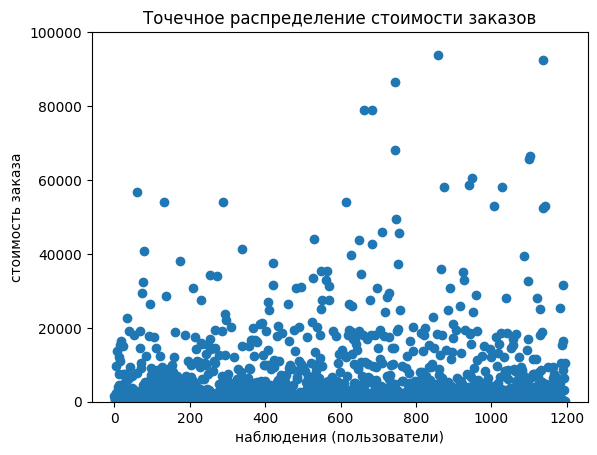

In [20]:
plt.scatter(x_values, orders['revenue'])
plt.title('Точечное распределение стоимости заказов')
plt.xlabel('наблюдения (пользователи)')
plt.ylabel('стоимость заказа')
plt.ylim(0, 100000)
plt.show()

**Комментарий:** теперь график более информативный, можно выделить, что очень много заказов превышают медианну (50%) равную 2,978, что объясняется высоким значением стандартного отклонения. Также влияние аномальных значений отражается в среднем арифметическом значении, которое значительно превышает медианну и равно 8,348.

#### 2.9 95-й и 99-й перцентили стоимости заказов.

In [21]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

**Комментарий:** только 5% пользователей совершили заказа на сумму 28000 и более, 1% пользователей совершил заказы на сумму 58233 и более.  
Границей для аномальных значений стоимости заказа выбрана значение 99-го перцентиля - 58233.

---

#### Далее будет расчитанна статистическая значимости колличества заказов и среднего чека по сырым и очищенным данным.

Подготовка данных:

In [22]:
# visitors_a_daily and visitors_a_cummulative
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_a_cummulative']



# visitors_b_daily and visitors_b_cummulative
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_b_cummulative']



# orders_a_daily and orders_a_cummulative
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = ['date', 'orders_cummulative_a', 'revenue_cummulative_a']



# orders_b_daily and orders_b_cummulative
orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = ['date', 'orders_cummulative_b', 'revenue_cummulative_b']



# конечная data
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

In [23]:
# создадим переменные с пользователями, где укажим колличество заказов для пользователей из разных групп
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

In [24]:
# создадим переменные, где пользователям будет соответствовать кол-во заказов или нули, если заказов нет
# нули для пользователей без заказов - это разница между суммой посетителей и количеством записей о заказах 
sample_a = pd.concat([
    orders_by_users_a['orders'],
    pd.Series(
        0,
        index=np.arange(
            data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
        ), name='orders')],axis=0
)

sample_b = pd.concat([
    orders_by_users_b['orders'],
    pd.Series(
        0,
        index=np.arange(
            data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
        ), name='orders')],axis=0
)

#### 2.10 Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Данные подготовлены, можно приступать к расчету статистической значимости.  
Для задачи 2.10 сформулируем нулевую и альтернативную гипотезу: 
- **Нулевая:** различий в среднем колличестве заказов между группами по сырым данным нет
- **Альтернативная:** различия в среднем колличестве заказов между группами по сырым данным есть  

Для всего последующего исследования зададим **уровень статистической значимости - 5%.**

In [25]:
display('p-value = {0:.3f}'.format(stats.mannwhitneyu(sample_a, sample_b)[1]))

display('Относительный прирост группы B к группе А - {0:.3%}'.format(sample_b.mean() / sample_a.mean() - 1))

'p-value = 0.017'

'Относительный прирост группы B к группе А - 13.808%'

**Комментарий:** получили p-value, равный 0.017 что меньше заданного уровня статистической значимости.  
Следовательно - **Отвергаем нулевую гипотезу, среди групп есть видимые различия.**  
Прирост группы B по отношению к группе А на сырых данных - **13%**, посмотрим, что получится после очистки данных от аномалий.

#### 2.11  Статистическая значимость различий в среднем чеке заказа между группами.

Аналогично сформулируем нулевую и альтернативную гипотезу: 
- **Нулевая:** различий в среднем чеке заказа между группами по сырым данным нет
- **Альтернативная:** различия в среднем чеке заказа между группами по сырым данным есть

In [26]:
display(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
    )
)
display(
    'Относительный прирост группы B к группе А - {0:.3%}'.format(
        orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1
    )
)

'p-value = 0.729'

'Относительный прирост группы B к группе А - 25.871%'

**Комментарий:** при таком p-value мы не можем считать группы статистически разными.  
Следовательно - **Не получилось отвергнуть нулевую гипотезу, значимых различий нет**  
В тоже время прирост группы B по отношению к группе А на сырых данных целых **25%**, очень значимая разница. 

#### 2.12 Статистическая значимость различий в среднем количестве заказов на посетителя между группами по очищенным данным.

Ранее мы установили параметры согласно которым пользователи считаются аномальными, это колличество заказов более 4-х и сама стоимость заказа свыше 58233. Далее сделаем срез данных и проведем сравнение групп по получившимся данным, так будет понятно искажают ли аномалии результаты теста.

In [27]:
# найдем всех аномальных пользователей 
users_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 4]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 4]['visitor_id'],
    ],
    axis=0,
)
users_expensive_orders = orders[orders['revenue'] > 58233]['visitor_id']
abnormal_users = (
    pd.concat([users_many_orders, users_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

display(abnormal_users.shape[0]) 

15

Всего 15 аномальных пользователей.  
Создадим группы без данных аномальных пользователей:

In [28]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Проверим гипотезу равенства групп по очищенным данным. Вновь сформулируем гипотезы:  
- **Нулевая:** различий в среднем колличестве заказов между группами по очищенным данным нет
- **Альтернативная:** различия в среднем колличестве заказов между группами по очищенным данным есть  


In [29]:
display('p-value = {0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
display('Относительный прирост группы B к группе А - {0:.3%}'.format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))


'p-value = 0.011'

'Относительный прирост группы B к группе А - 15.926%'

**Комментарий:** p-value также меньше уровня значимости.  
Следовательно - **Отвергаем нулевую гипотезу, среди групп есть видимые различия.**  
В тоже время прирост группы B по отношению к группе А даже увеличился и составил 15.926% против 13.808% на сырых данных.

#### 2.13 Статистическая значимость различий в среднем чеке заказа между группами по очищенным данным.

И здесь сформулируем нулевую и альтернативную гипотезу: 
- **Нулевая:** различий в среднем чеке заказа между группами по очищенным данным нет
- **Альтернативная:** различия в среднем чеке заказа между группами по очищенным данным есть

In [30]:
display(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

display(
    "Относительный прирост группы B к группе А - {0:.3%}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

'p-value = 0.851'

'Относительный прирост группы B к группе А - -0.575%'

**Комментарий:** группы стали еще более похожими за счет роста значения p-value.   
Следовательно - **Не получилось отвергнуть нулевую гипотезу, значимых различий нет**  
На этом фоне исчез значимый прирост группы B равный 25% и сейчас составляет -0.5%.

---

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
     
**Заключение по анализу A/B-теста**
---
**Обзор проделанной работы:**
- достигнута цель исследования, сформированно рациональное решение по A/B-тесту;
- проведена предобработка данных исходного массива данных;
- проведена приоритизация гипотез, выделены основные гипотезы;
- изучены кумулятивные метрики;
- расчитанна статистическая значимость групп теста.

---
**Приоритизация гипотез:**  
Для приоритизации гипотез были использованы методы ICE и RICE.  
Метод ICE включает в себя компоненты Impact (насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта), Confidence (насколько вы уверены, что это изменение повлияет на пользователей именно так), Efforts (сколько стоит протестировать эту гипотезу). Отличие метод RICE - это дополнительная метрика Reach (скольких пользователей затронет изменение, которое вы хотите внести).  
    
Согласно методу ICE в первую очередь стоит рассмотреть следующие гипотезы:
- запустить акцию, дающую скидку на товар в день рождения;
- добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;	
- добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.
    
Если брать во внимание еще и охват, то согласно методу RICE важны следующие гипотезы:
- добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.
    
       
---
**Анализ A/B-теста:**  
- кумулятивные метрики показывают преимущество колличества заказов группы B;
- проведено сравнение групп теста на колличеству заказов, имеются статистически значимые различия между группами. Прирост колличества заказов группы "B" по отношению к группе "А" положительный как на сырых, так и на очищенных данных без выбросов, 13.808% и 15.926% соответственно;  
- средний чек групп статистически не отличается, но на сырых данных значение прироста среднего чека группы "B" на целых 25% больше. После очистки данных от аномальных значений группы становятся более похожими, также пропадает отличие в приросте среднего чека.
---
**Рекомендация**:  
Исходя из результатов исследования рекомендую **остановить тест и зафиксировать победу группы B**.
</div>
